In [1]:
import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp2d
from matplotlib.animation import FuncAnimation, PillowWriter

from nv_files.Field_Generator import omega0_samples,omega0_samples_torch
from nv_files.FEM_Solver import VorticitySolver
from nv_files.Pseudo_Spectral_Solver import VorticitySolver2D



import torch
from ml_collections import ConfigDict
from scipy.interpolate import griddata

from nv_files.data_generator import solve_poisson_fft,compute_velocity,UniformSampler
from nv_files.NavierStokes import NavierStokes
from nv_files.Pseudo_Spectral_Solver import VorticitySolver2D

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# DeepGaLa

In [5]:
from nv_files.train_nvs import ic_vort_samples,data_vor_set_preparing
from Base.lla import dgala


def get_deepgalerkin_config():
    config = ConfigDict()

    # Training settings
    config.seed = 10

    config.chunks = 16
    config.points_per_chunk = 250
 

    # For deep Galerkin
    config.dim_initial_condition = 128
    config.tau = np.sqrt(2)
    config.d = 5

    config.time_domain = 2
    config.NKL =  1
    config.samples_size_initial = 1000
    
    return config

config = get_deepgalerkin_config()

initial_points,w0,theta = ic_vort_samples(config)

batch_size_interior = config.chunks*config.points_per_chunk

dom = torch.tensor([[0, 2 * torch.pi], [0, 2 * torch.pi],[0,config.time_domain]]).to(device)

samples_interior = iter(UniformSampler(dom, batch_size_interior,device=device))

batch = next(samples_interior).to(device)

sorted_batch,initial_points_,initial_condition = data_vor_set_preparing(config,batch, 
                                                    initial_points,w0,theta,batch_size_interior,0)

In [26]:

dom = torch.tensor([[0, 2 * torch.pi], [0, 2 * torch.pi],[0,config.time_domain]]).to(device)

samples_interior = iter(UniformSampler(dom, 10,device=device))

batch = next(samples_interior).to(device)


In [27]:
data_trainig = {"data_fit": {"pde":sorted_batch, "initial_conditions":(initial_condition,initial_points_)}, 
                "class_method": {"pde": ["nv_pde"], "initial_conditions":["w"]},
                "outputs": {"pde": ["nvs", "cond"], "initial_conditions": ["w0"]}}

In [28]:
MDNN_dg = torch.load(f"./models/vorticity_kl1_s250.pth")
MDNN_dg.eval()

Vorticity(
  (model): MDNN(
    (activation_fn): Tanh()
    (period_layer): PeriodEmbs()
    (fourier_layer): FourierEmbs()
    (u_layer): Linear(in_features=302, out_features=302, bias=True)
    (v_layer): Linear(in_features=302, out_features=302, bias=True)
    (hidden_layers): ModuleList(
      (0-2): 3 x Linear(in_features=302, out_features=302, bias=True)
    )
    (output_layer): Linear(in_features=302, out_features=2, bias=True)
  )
)

In [29]:
llp = dgala(MDNN_dg)

llp.fit(data_trainig)

In [30]:
from Base.utilities import clear_hooks

clear_hooks(llp)
torch.save(llp, f"./models/nvs_lla2.pth")

In [10]:
eingen = torch.real(torch.linalg.eig(llp.H)[0])
eingen[eingen<0]

tensor([])

In [11]:
eingen

tensor([1.4905e+05, 8.2858e+04, 6.5130e+04, 6.0340e+04, 5.5484e+04, 5.1745e+04,
        4.8991e+04, 4.5703e+04, 4.4849e+04, 4.0639e+04, 4.0339e+04, 3.6916e+04,
        3.5955e+04, 3.4974e+04, 3.3474e+04, 3.1470e+04, 3.0908e+04, 3.0265e+04,
        2.9257e+04, 2.8371e+04, 2.7358e+04, 2.6528e+04, 2.5497e+04, 2.4854e+04,
        2.3260e+04, 2.2991e+04, 2.2019e+04, 2.1225e+04, 2.0670e+04, 1.9320e+04,
        1.9273e+04, 1.8255e+04, 1.7719e+04, 1.7019e+04, 1.6283e+04, 1.5508e+04,
        1.4701e+04, 1.4460e+04, 1.4085e+04, 1.3717e+04, 1.3226e+04, 1.3123e+04,
        1.2337e+04, 1.2242e+04, 1.1900e+04, 1.1518e+04, 1.1026e+04, 1.0835e+04,
        1.0532e+04, 1.0276e+04, 9.8826e+03, 9.6609e+03, 9.7300e+03, 9.0955e+03,
        8.9225e+03, 8.6840e+03, 8.3849e+03, 8.3224e+03, 8.1107e+03, 7.9013e+03,
        7.7286e+03, 7.5460e+03, 7.3816e+03, 7.2213e+03, 6.9742e+03, 6.9114e+03,
        6.6801e+03, 6.6193e+03, 6.5485e+03, 6.4097e+03, 6.3517e+03, 6.0837e+03,
        5.9067e+03, 5.7943e+03, 5.7088e+

Text(0.5, 1.0, 'Marg.Lik: Prior Prec.')

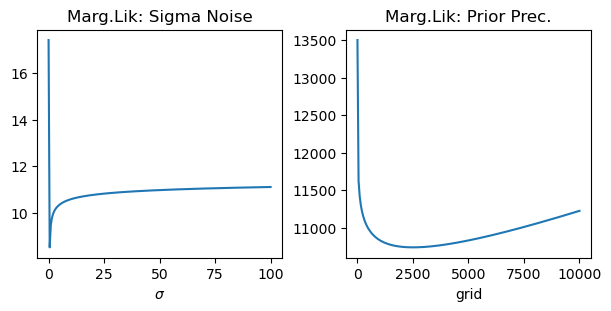

In [31]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')

llp = torch.load(f"./models/nvs_lla2.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

sn = torch.linspace(0.0001,100, 200)  # Spatial grid in X direction
log_marg_lh = []
for sn_val in sn:
    llp.sigma_noise = sn_val
    log_marg_lh.append(-llp.log_marginal_likelihood())
axs[0].plot(sn,np.log(log_marg_lh))
axs[0].set_xlabel("$\sigma$")
axs[0].set_title("Marg.Lik: Sigma Noise")

llp = torch.load(f"./models/nvs_lla2.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

priorpre = torch.linspace(0.1,10000, 200)  # Spatial grid in X direction
log_marg_pp = []
for pp in priorpre:
    llp.prior_precision = [pp]
    log_marg_pp.append(-llp.log_marginal_likelihood())

axs[1].plot(priorpre,log_marg_pp)
axs[1].set_xlabel("grid")
axs[1].set_title("Marg.Lik: Prior Prec.")

In [3]:
llp = torch.load(f"./models/nvs_lla.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks
llp.prior_precision = 1.
# print(llp._H_factor, torch.linalg.norm(llp.H,ord=2),torch.linalg.norm(llp.prior_precision_diag,ord=2))
# print(torch.linalg.norm(llp.posterior_precision))
llp.optimize_marginal_likelihood(error_tolerance=1e-3, max_iter=5000)
print(llp.sigma_noise,llp.prior_precision)
# print(llp._H_factor, torch.linalg.norm(llp.H,ord=2),torch.linalg.norm(llp.prior_precision_diag,ord=2))
# print(torch.linalg.norm(llp.posterior_precision))

Iteration 100, Error: 0.01000, neg_marglik: 1528.65747
Iteration 200, Error: 0.00998, neg_marglik: -9839.11719
Iteration 300, Error: 0.00983, neg_marglik: -21032.51172
Iteration 400, Error: 0.00880, neg_marglik: -31029.70703
Iteration 500, Error: 0.00434, neg_marglik: -36116.88672
tensor(0.0082) tensor([1.])


In [12]:
llp.log_likelihood 

tensor(41243.8945)

In [13]:
llp.log_det_ratio

tensor(4760.4370)

In [14]:
llp.scatter

tensor(517.6328)

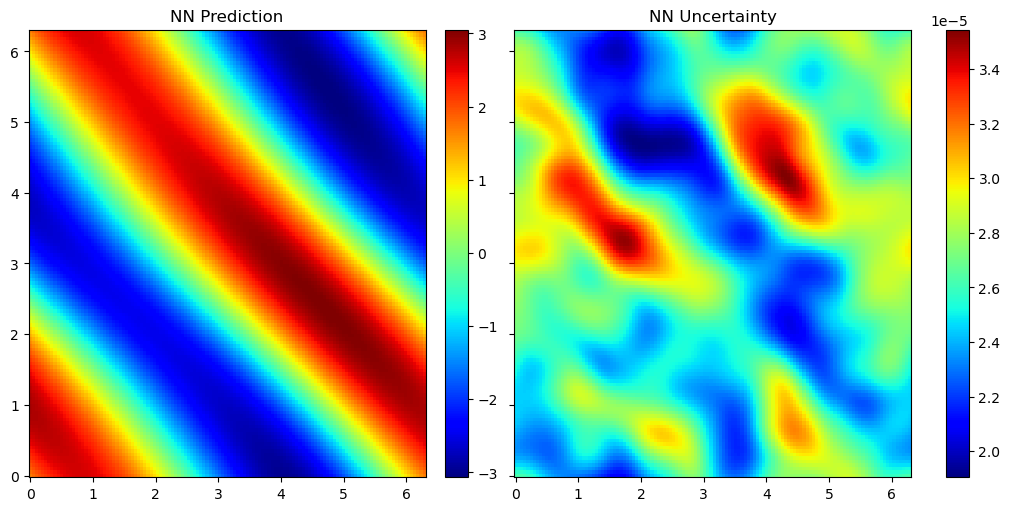

In [18]:
X = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in X direction
Y = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in Y direction
X, Y = torch.meshgrid(X, Y)  # Create meshgrid for X, Y

data_test = torch.hstack((X.reshape(-1,1),Y.reshape(-1,1),2*torch.ones_like(X.reshape(-1,1)))).float()

#th1 = theta[:,:,100].reshape(-1,1).T.repeat_interleave(data_test.shape[0], dim=0)
th1 = torch.tensor((-.8,.8)).reshape(-1,1).T.repeat_interleave(data_test.shape[0], dim=0)
llp.sigma_noise = 0.021
dataset1 = torch.cat((data_test, th1), dim=1)  # Shape (16000, 103)

surg_mu, surg_sigma = llp(dataset1)

surg_mu = surg_mu[:,0].view(-1, 1).detach().numpy()

surg_sigma = surg_sigma[:, 0].view(-1, 1).detach().numpy()

pred_mu = griddata((X.reshape(-1), Y.reshape(-1)), surg_mu.flatten(),(X, Y), method='cubic')
pred_sigma = griddata((X.reshape(-1), Y.reshape(-1)), surg_sigma.flatten(),(X, Y), method='cubic')


fig, axs = plt.subplots(1,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)

pcm1 = axs[0].pcolormesh(X, Y, pred_mu, cmap='jet')
axs[0].set_title("NN Prediction")
plt.colorbar(pcm1)

pcm = axs[1].pcolormesh(X, Y, pred_sigma, cmap='jet')
axs[1].set_title("NN Uncertainty")
plt.colorbar(pcm)